## Fig S12: Changing the copy number of activators in a double activation promoter.

In [1]:
# processing
import math
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

### Loading input data

In [2]:
_genome = []
for record in SeqIO.parse("../../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [3]:
# Promoter
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

# Operator sequence
rep_site = 'AATTGTGAGCGGATAACAATT'

## Find the transcription start site
df = pd.read_csv('../../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)
promoter

'ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAATGTGAGTTAGCTCACTCATTAGGCACCCCAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGGAATTGTGAGCGGATAACAATTTCACACAGGAAACAGCTATGACCA'

In [4]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

### Double activation

In [5]:
act1_site = promoter[(115 - 90 + 15):(115 - 90 + 25)]
act2_site = promoter[(115 - 90 + 35):(115 - 90 + 45)]
a1_emat = tregs.simulate.generate_emap(act1_site, fixed=True, fixed_value=1)
a2_emat = tregs.simulate.generate_emap(act2_site, fixed=True, fixed_value=1)

In [6]:
num_mutants = 200

mutant_bank = []
for i in range(num_mutants):
    mutants = np.unique(tregs.wgregseq.mutations_rand(promoter,
                                                rate=0.1,
                                                num_mutants=5000,
                                                number_fixed=True,
                                                keep_wildtype=True))
    mutant_bank.append(mutants)

In [11]:
n_NS = len(genome)
ep_wt, ea1_wt, ea2_wt = -2, -7, -7
e_int_pa1, e_int_pa2, e_int_a1a2 = -4, -4, -4
n_p, n_a2 = 5000, 25
l_n_a1 = np.arange(0, 51, 2)

a1_AND = np.zeros((len(l_n_a1), num_mutants))
a2_AND = np.zeros((len(l_n_a1), num_mutants))

for i, n_a1 in enumerate(l_n_a1):
    for j in range(num_mutants):
        df = tregs.simulate.sim(promoter, tregs.simulate.doubleact_pbound,
                                [rnap_site, act1_site, act2_site],
                                *[n_NS, n_p, n_a1, n_a2, rnap_emat, a1_emat, a2_emat, ep_wt, ea1_wt, ea2_wt, e_int_a1a2, e_int_pa1, e_int_pa2, 'AND'],
                                preset_mutants=mutant_bank[j],
                                scaling_factor=100)

        mut_list = df['seq'].values
        mu_data = df['norm_ct_1']
        nbins = 2
        upper_bound = np.mean(mu_data)

        footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                    pseudocount=10**(-6))
        a1_AND[i, j] = np.mean(footprint[(115 - 90 + 15):(115 - 90 + 25)])
        a2_AND[i, j] = np.mean(footprint[(115 - 90 + 35):(115 - 90 + 45)])

In [12]:
n_NS = len(genome)
ep_wt, ea1_wt, ea2_wt = -2, -7, -7
e_int_pa1, e_int_pa2, e_int_a1a2 = -7, -7, -7
n_p, n_a2 = 5000, 25
l_n_a1 = np.arange(0, 51, 2)

a1_OR = np.zeros((len(l_n_a1), num_mutants))
a2_OR = np.zeros((len(l_n_a1), num_mutants))

for i, n_a1 in enumerate(l_n_a1):
    for j in range(num_mutants):
        df = tregs.simulate.sim(promoter, tregs.simulate.doubleact_pbound,
                                [rnap_site, act1_site, act2_site],
                                *[n_NS, n_p, n_a1, n_a2, rnap_emat, a1_emat, a2_emat, ep_wt, ea1_wt, ea2_wt, e_int_a1a2, e_int_pa1, e_int_pa2, 'OR'],
                                preset_mutants=mutant_bank[j],
                                scaling_factor=100)

        mut_list = df['seq'].values
        mu_data = df['norm_ct_1']
        nbins = 2
        upper_bound = np.mean(mu_data)

        footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                    pseudocount=10**(-6))
        a1_OR[i, j] = np.mean(footprint[(115 - 90 + 15):(115 - 90 + 25)])
        a2_OR[i, j] = np.mean(footprint[(115 - 90 + 35):(115 - 90 + 45)])

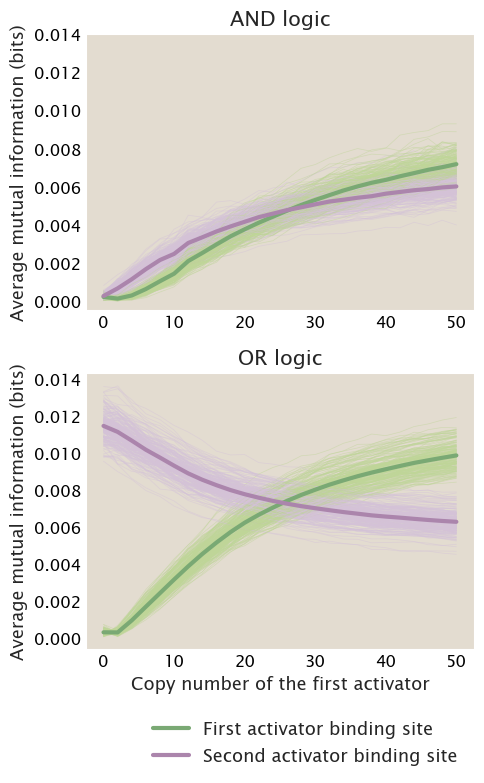

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(5,8))
ax1, ax2 = axes

for i in range(num_mutants):
    ax1.plot(l_n_a1, a1_AND[:, i], color='#BFD598', alpha=0.5, linewidth=0.5)
    ax1.plot(l_n_a1, a2_AND[:, i], color='#D4C2D9', alpha=0.5, linewidth=0.5)
ax1.plot(l_n_a1, np.mean(a1_AND, axis=1), label='First activator binding site', color='#7AA974', linewidth=3)
ax1.plot(l_n_a1, np.mean(a2_AND, axis=1), label='Second activator binding site', color='#AB85AC', linewidth=3)
ax1.set_ylabel('Average mutual information (bits)', fontsize=13)
ax1.set_title('AND logic', fontsize=15)
ax1.set_yticks(np.arange(0, 0.015, 0.002))

for i in range(num_mutants):
    ax2.plot(l_n_a1, a1_OR[:, i], color='#BFD598', alpha=0.5, linewidth=0.5)
    ax2.plot(l_n_a1, a2_OR[:, i], color='#D4C2D9', alpha=0.5, linewidth=0.5)
ax2.plot(l_n_a1, np.mean(a1_OR, axis=1), label='First activator binding site', color='#7AA974', linewidth=3)
ax2.plot(l_n_a1, np.mean(a2_OR, axis=1), label='Second activator binding site', color='#AB85AC', linewidth=3)
ax2.set_xlabel('Copy number of the first activator', fontsize=13)
ax2.set_ylabel('Average mutual information (bits)', fontsize=13)
ax2.set_title('OR logic', fontsize=15)
ax2.legend(bbox_to_anchor=(1, -0.2), frameon=False, fontsize=13)

plt.tight_layout()
plt.savefig('../plots/figS10/knockout_doubleact.pdf')

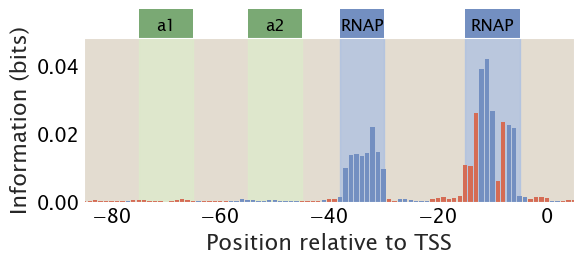

In [6]:
n_NS = len(genome)
ep_wt, ea1_wt, ea2_wt = -2, -7, -7
e_int_pa1, e_int_pa2, e_int_a1a2 = -4, -4, -4
n_p, n_a1, n_a2 = 5000, 0, 25

df = tregs.simulate.sim(promoter, tregs.simulate.doubleact_pbound, [rnap_site, act1_site, act2_site],
                        *[n_NS, n_p, n_a1, n_a2, rnap_emat, a1_emat, a2_emat, ep_wt, ea1_wt, ea2_wt, e_int_a1a2, e_int_pa1, e_int_pa2, 'AND'], scaling_factor=100)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-75, -65, 'A', 'a1'), (-55, -45, 'A', 'a2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-85, 5), fig_width=6, annotate_stn=False,
                               legend_xcoord=1.35,
                               outfile='../plots/figS10/knockout_doubleact_AND_fp1.pdf')

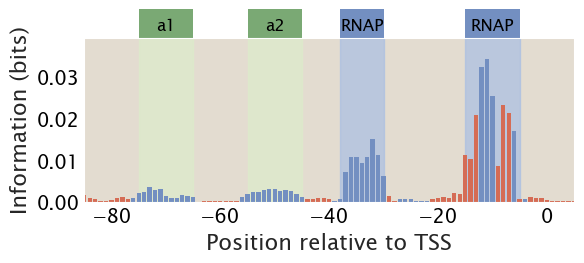

In [7]:
n_NS = len(genome)
ep_wt, ea1_wt, ea2_wt = -2, -7, -7
e_int_pa1, e_int_pa2, e_int_a1a2 = -4, -4, -4
n_p, n_a1, n_a2 = 5000, 10, 25

df = tregs.simulate.sim(promoter, tregs.simulate.doubleact_pbound, [rnap_site, act1_site, act2_site],
                        *[n_NS, n_p, n_a1, n_a2, rnap_emat, a1_emat, a2_emat, ep_wt, ea1_wt, ea2_wt, e_int_a1a2, e_int_pa1, e_int_pa2, 'AND'], scaling_factor=100)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-75, -65, 'A', 'a1'), (-55, -45, 'A', 'a2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-85, 5), fig_width=6, annotate_stn=False,
                               legend_xcoord=1.35,
                               outfile='../plots/figS10/knockout_doubleact_AND_fp2.pdf')

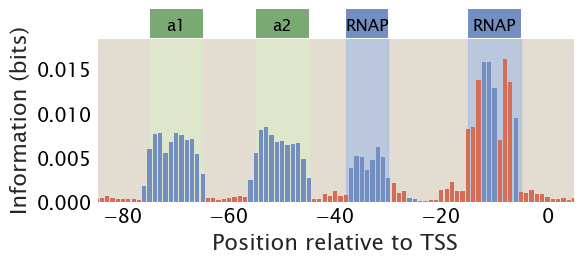

In [8]:
n_NS = len(genome)
ep_wt, ea1_wt, ea2_wt = -2, -7, -7
e_int_pa1, e_int_pa2, e_int_a1a2 = -4, -4, -4
n_p, n_a1, n_a2 = 5000, 50, 25

df = tregs.simulate.sim(promoter, tregs.simulate.doubleact_pbound, [rnap_site, act1_site, act2_site],
                        *[n_NS, n_p, n_a1, n_a2, rnap_emat, a1_emat, a2_emat, ep_wt, ea1_wt, ea2_wt, e_int_a1a2, e_int_pa1, e_int_pa2, 'AND'], scaling_factor=100)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-75, -65, 'A', 'a1'), (-55, -45, 'A', 'a2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-85, 5), fig_width=6, annotate_stn=False,
                               legend_xcoord=1.35,
                               outfile='../plots/figS10/knockout_doubleact_AND_fp3.pdf')

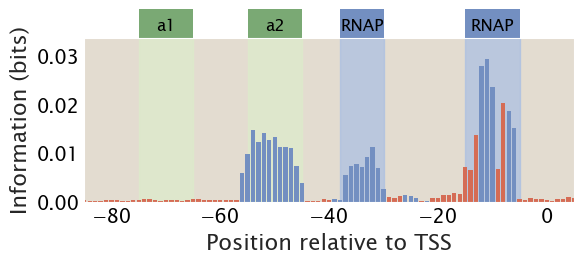

In [9]:
n_NS = len(genome)
ep_wt, ea1_wt, ea2_wt = -2, -7, -7
e_int_pa1, e_int_pa2, e_int_a1a2 = -7, -7, -7
n_p, n_a1, n_a2 = 5000, 0, 25

df = tregs.simulate.sim(promoter, tregs.simulate.doubleact_pbound, [rnap_site, act1_site, act2_site],
                        *[n_NS, n_p, n_a1, n_a2, rnap_emat, a1_emat, a2_emat, ep_wt, ea1_wt, ea2_wt, e_int_a1a2, e_int_pa1, e_int_pa2, 'OR'], scaling_factor=100)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-75, -65, 'A', 'a1'), (-55, -45, 'A', 'a2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-85, 5), fig_width=6, annotate_stn=False,
                               legend_xcoord=1.35,
                               outfile='../plots/figS10/knockout_doubleact_OR_fp1.pdf')

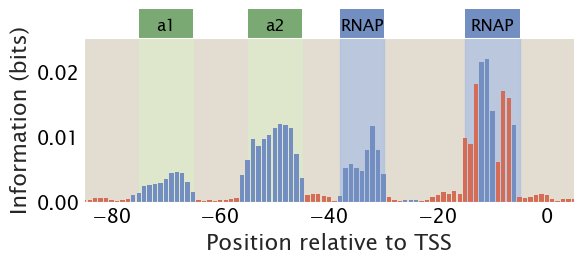

In [10]:
n_NS = len(genome)
ep_wt, ea1_wt, ea2_wt = -2, -7, -7
e_int_pa1, e_int_pa2, e_int_a1a2 = -7, -7, -7
n_p, n_a1, n_a2 = 5000, 10, 25

df = tregs.simulate.sim(promoter, tregs.simulate.doubleact_pbound, [rnap_site, act1_site, act2_site],
                        *[n_NS, n_p, n_a1, n_a2, rnap_emat, a1_emat, a2_emat, ep_wt, ea1_wt, ea2_wt, e_int_a1a2, e_int_pa1, e_int_pa2, 'OR'], scaling_factor=100)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-75, -65, 'A', 'a1'), (-55, -45, 'A', 'a2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-85, 5), fig_width=6, annotate_stn=False,
                               legend_xcoord=1.35,
                               outfile='../plots/figS10/knockout_doubleact_OR_fp2.pdf')

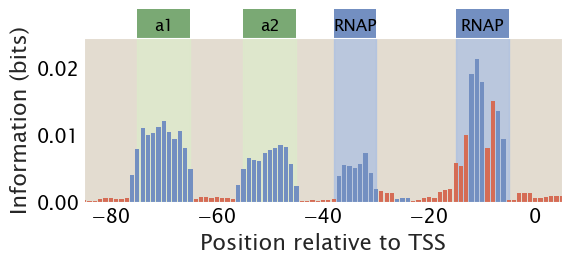

In [11]:
n_NS = len(genome)
ep_wt, ea1_wt, ea2_wt = -2, -7, -7
e_int_pa1, e_int_pa2, e_int_a1a2 = -7, -7, -7
n_p, n_a1, n_a2 = 5000, 50, 25

df = tregs.simulate.sim(promoter, tregs.simulate.doubleact_pbound, [rnap_site, act1_site, act2_site],
                        *[n_NS, n_p, n_a1, n_a2, rnap_emat, a1_emat, a2_emat, ep_wt, ea1_wt, ea2_wt, e_int_a1a2, e_int_pa1, e_int_pa2, 'OR'], scaling_factor=100)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-75, -65, 'A', 'a1'), (-55, -45, 'A', 'a2')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-85, 5), fig_width=6, annotate_stn=False,
                               legend_xcoord=1.35,
                               outfile='../plots/figS10/knockout_doubleact_OR_fp3.pdf')